In [6]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optim

# Load the full MNIST training set
mnist_train = dsets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)

In [7]:
# Split into 50,000 for training and 10,000 for validation
train_size = 50000
valid_size = 10000
mnist_sub_train, mnist_valid = random_split(mnist_train, [train_size, valid_size])

print('Sub Train Size:', len(mnist_sub_train))
print('Validation Size:', len(mnist_valid))

Sub Train Size: 50000
Validation Size: 10000


In [8]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0001
epochs = 25

# Initialize data loaders
sub_train_loader = DataLoader(dataset=mnist_sub_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=mnist_valid, batch_size=batch_size, shuffle=False)

In [14]:
# Custom Neural Network Class using SGD with Momentum
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(784, 64),  # Input layer with 64 neurons
            nn.ReLU()  # Activation function
        )

        self.hidden_layer2 = nn.Sequential(  # Second hidden layer
            nn.Linear(64, 32),  # 32 neurons
            nn.ReLU()  # Activation function
        )

        self.output_layer = nn.Linear(32, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.hidden_layer1(x)  # Pass through first hidden layer
        x = self.hidden_layer2(x)  # Pass through second hidden layer
        x = self.output_layer(x)  # Pass through output layer
        return x

# Determine the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
model_instance = SimpleNN().to(device)

# Set the loss function
loss_function = nn.CrossEntropyLoss().to(device)  # CrossEntropyLoss includes softmax

# Initialize the optimizer with SGD and momentum
learning_rate = 0.01
momentum_value = 0.9
weight_decay_value = 1e-4
optimizer_instance = optim.SGD(model_instance.parameters(), lr=learning_rate, momentum=momentum_value, weight_decay=weight_decay_value)

# Lists to track training and validation losses
training_losses = []
validation_losses = []

Epoch:    1, cost=0.610435069, Validation Loss: 0.3011
Epoch:    2, cost=0.234681413, Validation Loss: 0.2112
Epoch:    3, cost=0.167426109, Validation Loss: 0.1652
Epoch:    4, cost=0.130960077, Validation Loss: 0.1493
Epoch:    5, cost=0.108177148, Validation Loss: 0.1281
Epoch:    6, cost=0.092550270, Validation Loss: 0.1277
Epoch:    7, cost=0.079374216, Validation Loss: 0.1092
Epoch:    8, cost=0.069339193, Validation Loss: 0.1192
Epoch:    9, cost=0.060728207, Validation Loss: 0.1085
Epoch:   10, cost=0.055044442, Validation Loss: 0.1117
Epoch:   11, cost=0.049540263, Validation Loss: 0.1049
Epoch:   12, cost=0.045430399, Validation Loss: 0.0958
Epoch:   13, cost=0.039536938, Validation Loss: 0.1081
Epoch:   14, cost=0.035543025, Validation Loss: 0.1048
Epoch:   15, cost=0.033166129, Validation Loss: 0.0997
Epoch:   16, cost=0.029049270, Validation Loss: 0.0963
Epoch:   17, cost=0.025919680, Validation Loss: 0.0997
Epoch:   18, cost=0.023447378, Validation Loss: 0.1088
Epoch:   1

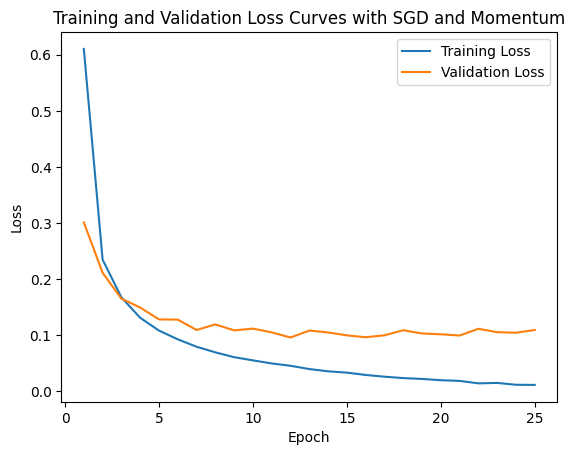

Test Accuracy: 97.30%


In [15]:
# Training and validation process
for epoch in range(epochs):
    model_instance.train()  # Set the model to training mode
    total_training_loss = 0
    average_cost = 0  # Reset average cost for each epoch

    for inputs, labels in sub_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_instance.zero_grad()  # Clear previous gradients

        # Forward pass
        predictions = model_instance(inputs)
        loss = loss_function(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer_instance.step()

        total_training_loss += loss.item()
        average_cost += loss / len(sub_train_loader)  # Accumulate cost for averaging

    # Calculate and store average training loss
    avg_training_loss = total_training_loss / len(sub_train_loader)
    training_losses.append(avg_training_loss)

    # Validation phase
    model_instance.eval()  # Set the model to evaluation mode
    total_validation_loss = 0
    with torch.no_grad():
        for inputs_val, labels_val in valid_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            predictions_val = model_instance(inputs_val)
            validation_loss = loss_function(predictions_val, labels_val)
            total_validation_loss += validation_loss.item()

    avg_validation_loss = total_validation_loss / len(valid_loader)
    validation_losses.append(avg_validation_loss)

    # Print average cost and validation loss
    print('Epoch: {:>4}, cost={:.9f}, Validation Loss: {:.4f}'.format(epoch + 1, average_cost.item(), avg_validation_loss))

import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.title('SGD')
plt.legend()
plt.show()

# Calculate test accuracy
model_instance.eval()  # Set the model to evaluation mode
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs_test, labels_test in valid_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        predictions_test = model_instance(inputs_test)
        _, predicted_labels = torch.max(predictions_test, 1)
        correct_predictions += (predicted_labels == labels_test).sum().item()
        total_samples += labels_test.size(0)

test_accuracy_percentage = correct_predictions / total_samples
print(f'Test Accuracy: {test_accuracy_percentage * 100:.2f}%')

In [18]:
class SimpleAdaGradModel(nn.Module):
    def __init__(self):
        super(SimpleAdaGradModel, self).__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(784, 64),  # Input layer with 64 neurons
            nn.ReLU()  # Activation function
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 32),  # Second hidden layer with 32 neurons
            nn.ReLU()  # Activation function
        )

        self.output_layer = nn.Linear(32, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.hidden_layer1(x)  # Pass through first hidden layer
        x = self.hidden_layer2(x)  # Pass through second hidden layer
        x = self.output_layer(x)  # Pass through output layer
        return x

# Determine the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
ada_grad_model = SimpleAdaGradModel().to(device)

# Set the loss function
loss_function = nn.CrossEntropyLoss().to(device)  # CrossEntropyLoss includes softmax

# Initialize the AdaGrad optimizer
ada_grad_optimizer = optim.Adagrad(ada_grad_model.parameters(), lr=0.01, weight_decay=1e-5, eps=1e-8)

# Lists to track training and validation losses
training_losses = []
validation_losses = []

Epoch:    1, cost=0.372695655, Validation Loss: 0.2794
Epoch:    2, cost=0.232698411, Validation Loss: 0.2311
Epoch:    3, cost=0.198531449, Validation Loss: 0.2137
Epoch:    4, cost=0.177583069, Validation Loss: 0.2012
Epoch:    5, cost=0.163689941, Validation Loss: 0.1876
Epoch:    6, cost=0.152304247, Validation Loss: 0.1784
Epoch:    7, cost=0.143503502, Validation Loss: 0.1715
Epoch:    8, cost=0.136658520, Validation Loss: 0.1648
Epoch:    9, cost=0.130404726, Validation Loss: 0.1606
Epoch:   10, cost=0.125209019, Validation Loss: 0.1580
Epoch:   11, cost=0.120869435, Validation Loss: 0.1538
Epoch:   12, cost=0.117182985, Validation Loss: 0.1516
Epoch:   13, cost=0.113030635, Validation Loss: 0.1471
Epoch:   14, cost=0.109413557, Validation Loss: 0.1453
Epoch:   15, cost=0.106193222, Validation Loss: 0.1427
Epoch:   16, cost=0.102878235, Validation Loss: 0.1402
Epoch:   17, cost=0.100128338, Validation Loss: 0.1381
Epoch:   18, cost=0.097538844, Validation Loss: 0.1358
Epoch:   1

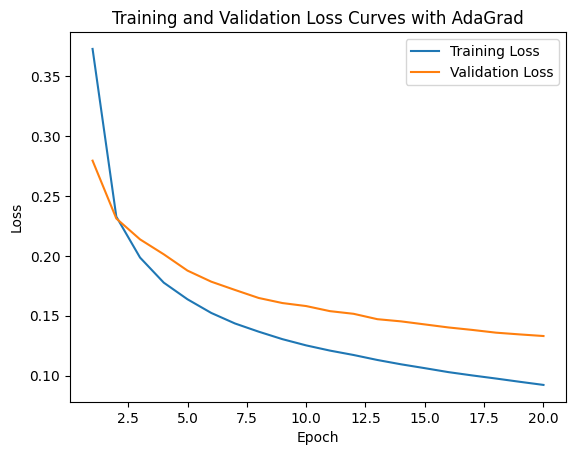

Test Accuracy: 96.18%


In [19]:
# Training and validation process
for epoch in range(num_epochs):
    ada_grad_model.train()  # Set the model to training mode
    total_training_loss = 0
    average_cost = 0  # Reset average cost for each epoch

    for inputs, labels in sub_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        ada_grad_optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        predictions = ada_grad_model(inputs)
        loss = loss_function(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        ada_grad_optimizer.step()

        total_training_loss += loss.item()
        average_cost += loss / len(sub_train_loader)  # Accumulate cost for averaging

    # Calculate and store average training loss
    avg_training_loss = total_training_loss / len(sub_train_loader)
    training_losses.append(avg_training_loss)

    # Validation phase
    ada_grad_model.eval()  # Set the model to evaluation mode
    total_validation_loss = 0
    with torch.no_grad():
        for inputs_val, labels_val in valid_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            predictions_val = ada_grad_model(inputs_val)
            validation_loss = loss_function(predictions_val, labels_val)
            total_validation_loss += validation_loss.item()

    avg_validation_loss = total_validation_loss / len(valid_loader)
    validation_losses.append(avg_validation_loss)

    # Print average cost and validation loss
    print('Epoch: {:>4}, cost={:.9f}, Validation Loss: {:.4f}'.format(epoch + 1, average_cost.item(), avg_validation_loss))

import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('AdaGrad')
plt.legend()
plt.show()

# Calculate test accuracy
ada_grad_model.eval()  # Set the model to evaluation mode
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs_test, labels_test in valid_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        predictions_test = ada_grad_model(inputs_test)
        _, predicted_labels = torch.max(predictions_test, 1)
        correct_predictions += (predicted_labels == labels_test).sum().item()
        total_samples += labels_test.size(0)

test_accuracy_percentage = correct_predictions / total_samples
print(f'Test Accuracy: {test_accuracy_percentage * 100:.2f}%')

In [20]:
class SimpleRMSPropModel(nn.Module):
    def __init__(self):
        super(SimpleRMSPropModel, self).__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(784, 64),  # Input layer with 64 neurons
            nn.ReLU()  # Activation function
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 32),  # Second hidden layer with 32 neurons
            nn.ReLU()  # Activation function
        )

        self.output_layer = nn.Linear(32, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.hidden_layer1(x)  # Pass through first hidden layer
        x = self.hidden_layer2(x)  # Pass through second hidden layer
        x = self.output_layer(x)  # Pass through output layer
        return x

# Determine the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
rms_prop_model = SimpleRMSPropModel().to(device)

# Set the loss function
loss_function = nn.CrossEntropyLoss().to(device)  # CrossEntropyLoss includes softmax

# Initialize the RMSProp optimizer
rms_prop_optimizer = optim.RMSprop(rms_prop_model.parameters(), lr=0.001, alpha=0.9, weight_decay=1e-5)

# Lists to track training and validation losses
training_losses = []
validation_losses = []

Epoch:    1, cost=0.451718986, Validation Loss: 0.2706
Epoch:    2, cost=0.216838136, Validation Loss: 0.2217
Epoch:    3, cost=0.164101839, Validation Loss: 0.1873
Epoch:    4, cost=0.131179914, Validation Loss: 0.1471
Epoch:    5, cost=0.109925389, Validation Loss: 0.1461
Epoch:    6, cost=0.093865737, Validation Loss: 0.1520
Epoch:    7, cost=0.081601381, Validation Loss: 0.1245
Epoch:    8, cost=0.073344611, Validation Loss: 0.1249
Epoch:    9, cost=0.064594574, Validation Loss: 0.1174
Epoch:   10, cost=0.058405239, Validation Loss: 0.1136
Epoch:   11, cost=0.050886597, Validation Loss: 0.1126
Epoch:   12, cost=0.046366729, Validation Loss: 0.1093
Epoch:   13, cost=0.042646021, Validation Loss: 0.1164
Epoch:   14, cost=0.038552072, Validation Loss: 0.1192
Epoch:   15, cost=0.035621412, Validation Loss: 0.1123
Epoch:   16, cost=0.032371953, Validation Loss: 0.1116
Epoch:   17, cost=0.029945295, Validation Loss: 0.1201
Epoch:   18, cost=0.027571153, Validation Loss: 0.1157
Epoch:   1

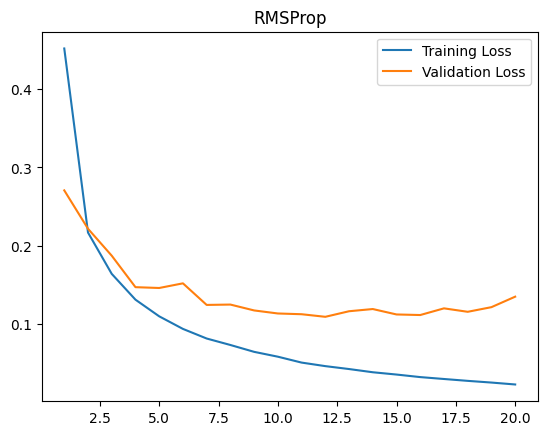

Test Accuracy: 97.06%


In [21]:
# Training and validation process
for epoch in range(num_epochs):
    rms_prop_model.train()  # Set the model to training mode
    total_training_loss = 0
    average_cost = 0  # Reset average cost for each epoch

    for inputs, labels in sub_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        rms_prop_optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        predictions = rms_prop_model(inputs)
        loss = loss_function(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        rms_prop_optimizer.step()

        total_training_loss += loss.item()
        average_cost += loss / len(sub_train_loader)  # Accumulate cost for averaging

    # Calculate and store average training loss
    avg_training_loss = total_training_loss / len(sub_train_loader)
    training_losses.append(avg_training_loss)

    # Validation phase
    rms_prop_model.eval()  # Set the model to evaluation mode
    total_validation_loss = 0
    with torch.no_grad():
        for inputs_val, labels_val in valid_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            predictions_val = rms_prop_model(inputs_val)
            validation_loss = loss_function(predictions_val, labels_val)
            total_validation_loss += validation_loss.item()

    avg_validation_loss = total_validation_loss / len(valid_loader)
    validation_losses.append(avg_validation_loss)

    # Print average cost and validation loss
    print('Epoch: {:>4}, cost={:.9f}, Validation Loss: {:.4f}'.format(epoch + 1, average_cost.item(), avg_validation_loss))


# Plotting the training and validation loss curves
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.title('RMSProp')
plt.legend()
plt.show()

# Calculate test accuracy
rms_prop_model.eval()  # Set the model to evaluation mode
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs_test, labels_test in valid_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        predictions_test = rms_prop_model(inputs_test)
        _, predicted_labels = torch.max(predictions_test, 1)
        correct_predictions += (predicted_labels == labels_test).sum().item()
        total_samples += labels_test.size(0)

test_accuracy_percentage = correct_predictions / total_samples
print(f'Test Accuracy: {test_accuracy_percentage * 100:.2f}%')

In [23]:
class SimpleAdamModel(nn.Module):
    def __init__(self):
        super(SimpleAdamModel, self).__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(784, 64),  # Input layer with 64 neurons
            nn.ReLU()  # Activation function
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 32),  # Second hidden layer with 32 neurons
            nn.ReLU()  # Activation function
        )

        self.output_layer = nn.Linear(32, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.hidden_layer1(x)  # Pass through first hidden layer
        x = self.hidden_layer2(x)  # Pass through second hidden layer
        x = self.output_layer(x)  # Pass through output layer
        return x

# Determine the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
adam_model = SimpleAdamModel().to(device)

# Set the loss function
loss_function = nn.CrossEntropyLoss().to(device)  # CrossEntropyLoss includes softmax

# Initialize the Adam optimizer
adam_optimizer = optim.Adam(adam_model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)

# Lists to track training and validation losses
training_losses = []
validation_losses = []

Epoch:    1, cost=0.456332892, Validation Loss: 0.2718
Epoch:    2, cost=0.219408050, Validation Loss: 0.1947
Epoch:    3, cost=0.159068838, Validation Loss: 0.1576
Epoch:    4, cost=0.125823513, Validation Loss: 0.1382
Epoch:    5, cost=0.104157433, Validation Loss: 0.1182
Epoch:    6, cost=0.088177197, Validation Loss: 0.1117
Epoch:    7, cost=0.075869650, Validation Loss: 0.1084
Epoch:    8, cost=0.067182116, Validation Loss: 0.1039
Epoch:    9, cost=0.060605712, Validation Loss: 0.1145
Epoch:   10, cost=0.055069719, Validation Loss: 0.0993
Epoch:   11, cost=0.048404139, Validation Loss: 0.1132
Epoch:   12, cost=0.042215094, Validation Loss: 0.1029
Epoch:   13, cost=0.040544726, Validation Loss: 0.0953
Epoch:   14, cost=0.035105359, Validation Loss: 0.1072
Epoch:   15, cost=0.033002991, Validation Loss: 0.1078
Epoch:   16, cost=0.029809425, Validation Loss: 0.1028
Epoch:   17, cost=0.028307807, Validation Loss: 0.1054
Epoch:   18, cost=0.026478911, Validation Loss: 0.1057
Epoch:   1

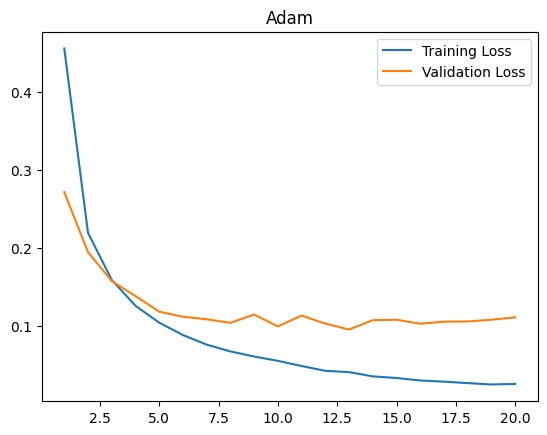

Test Accuracy: 96.99%


In [25]:
# Training and validation process
for epoch in range(num_epochs):
    adam_model.train()  # Set the model to training mode
    total_training_loss = 0
    average_cost = 0  # Reset average cost for each epoch

    for inputs, labels in sub_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        adam_optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        predictions = adam_model(inputs)
        loss = loss_function(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        adam_optimizer.step()

        total_training_loss += loss.item()
        average_cost += loss / len(sub_train_loader)  # Accumulate cost for averaging

    # Calculate and store average training loss
    avg_training_loss = total_training_loss / len(sub_train_loader)
    training_losses.append(avg_training_loss)

    # Validation phase
    adam_model.eval()  # Set the model to evaluation mode
    total_validation_loss = 0
    with torch.no_grad():
        for inputs_val, labels_val in valid_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            predictions_val = adam_model(inputs_val)
            validation_loss = loss_function(predictions_val, labels_val)
            total_validation_loss += validation_loss.item()

    avg_validation_loss = total_validation_loss / len(valid_loader)
    validation_losses.append(avg_validation_loss)

    # Print average cost and validation loss
    print('Epoch: {:>4}, cost={:.9f}, Validation Loss: {:.4f}'.format(epoch + 1, average_cost.item(), avg_validation_loss))

import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.title('Adam')
plt.legend()
plt.show()

# Calculate test accuracy
adam_model.eval()  # Set the model to evaluation mode
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs_test, labels_test in valid_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        predictions_test = adam_model(inputs_test)
        _, predicted_labels = torch.max(predictions_test, 1)
        correct_predictions += (predicted_labels == labels_test).sum().item()
        total_samples += labels_test.size(0)

test_accuracy_percentage = correct_predictions / total_samples
print(f'Test Accuracy: {test_accuracy_percentage * 100:.2f}%')